# Machine Learning for Concrete Strength Prediction: An Optimization Approach

Ready-to-run notebook. Place your dataset at `/mnt/data/Concrete.xlsx` and run all cells.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import joblib, os
print('Imports OK')

Imports OK


In [2]:
df = pd.read_csv('Concrete_Data_new.csv')
print('Loaded', df.shape)
display(df.head())
# ---  Clean up Column Names ---
df.columns = [
                'Cement', 'BlastFurnaceSlag', 'FlyAsh', 'Water', 'Superplasticizer',
                'CoarseAggregate', 'FineAggregate', 'Age', 'ConcreteStrength', 'W/C'
            ]


Loaded (1030, 10)


,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)",Water to Cement Ratio (W/C)
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99,0.300000
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89,0.300000
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27,0.685714
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05,0.685714
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30,0.966767


In [3]:
# The rest of the pipeline is in the notebook you received from the assistant.
# Run cells sequentially to perform EDA, training, tuning, and to save artifacts.
print('Continue running the notebook cells as needed.')
# Cell 3: quick EDA
print("Shape:", df.shape)
print(df.dtypes)
print("Missing values:\n", df.isnull().sum())
display(df.describe().T)

Continue running the notebook cells as needed.
Shape: (1030, 10)
Cement              float64
BlastFurnaceSlag    float64
FlyAsh              float64
Water               float64
Superplasticizer    float64
CoarseAggregate     float64
FineAggregate       float64
Age                   int64
ConcreteStrength    float64
W/C                 float64
dtype: object
Missing values:
 Cement              0
BlastFurnaceSlag    0
FlyAsh              0
Water               0
Superplasticizer    0
CoarseAggregate     0
FineAggregate       0
Age                 0
ConcreteStrength    0
W/C                 0
dtype: int64


,count,mean,std,min,25%,50%,75%,max
Cement,1030.0,281.167864,104.506364,102.000000,192.375000,272.900000,350.000000,540.000000
BlastFurnaceSlag,1030.0,73.895825,86.279342,0.000000,0.000000,22.000000,142.950000,359.400000
FlyAsh,1030.0,54.188350,63.997004,0.000000,0.000000,0.000000,118.300000,200.100000
Water,1030.0,181.567282,21.354219,121.800000,164.900000,185.000000,192.000000,247.000000
Superplasticizer,1030.0,6.204660,5.973841,0.000000,0.000000,6.400000,10.200000,32.200000
CoarseAggregate,1030.0,972.918932,77.753954,801.000000,932.000000,968.000000,1029.400000,1145.000000
FineAggregate,1030.0,773.580485,80.175980,594.000000,730.950000,779.500000,824.000000,992.600000
Age,1030.0,45.662136,63.169912,1.000000,7.000000,28.000000,56.000000,365.000000
ConcreteStrength,1030.0,35.817961,16.705742,2.330000,23.710000,34.445000,46.135000,82.600000
W/C,1030.0,0.748269,0.314005,0.266893,0.533333,0.675349,0.935014,1.882353


In [4]:
possible_targets = [c for c in df.columns if 'strength' in c.lower() or 'compressive' in c.lower()]
target_col = possible_targets[0] if possible_targets else df.columns[-1]
print("Target column:", target_col)

Target column: ConcreteStrength


4 Histogram

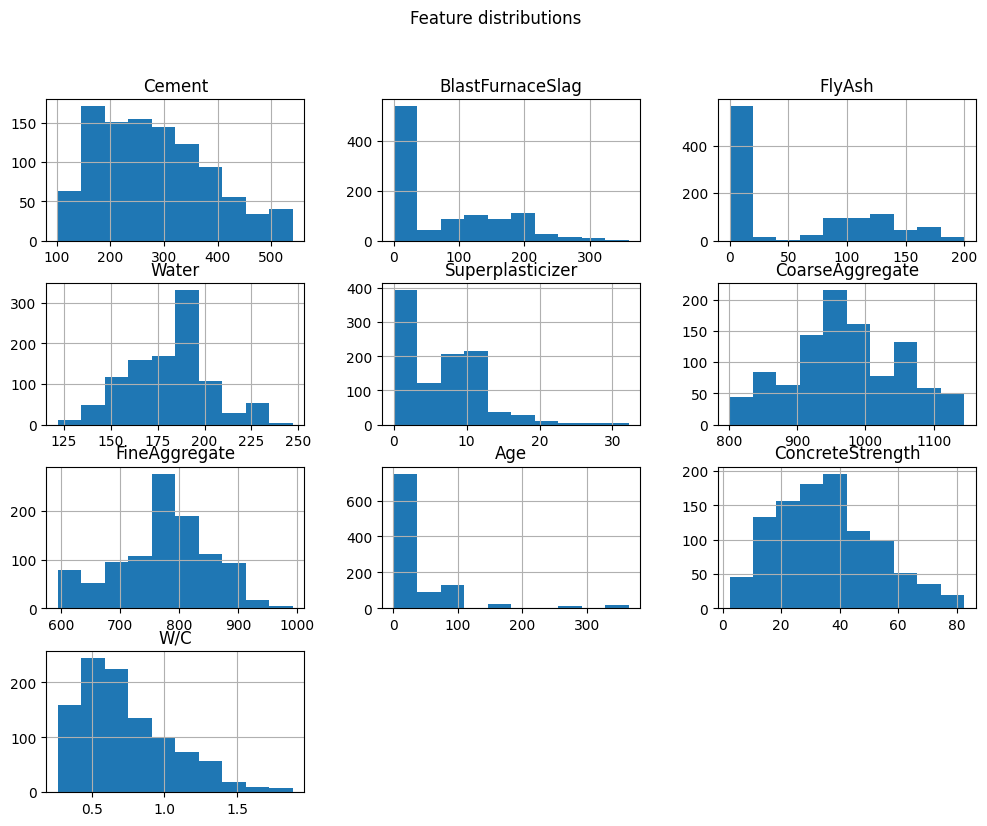

In [5]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[numeric_cols].hist(figsize=(12,9))
plt.suptitle("Feature distributions")
plt.show()

5. Correlation heatmap (simple)

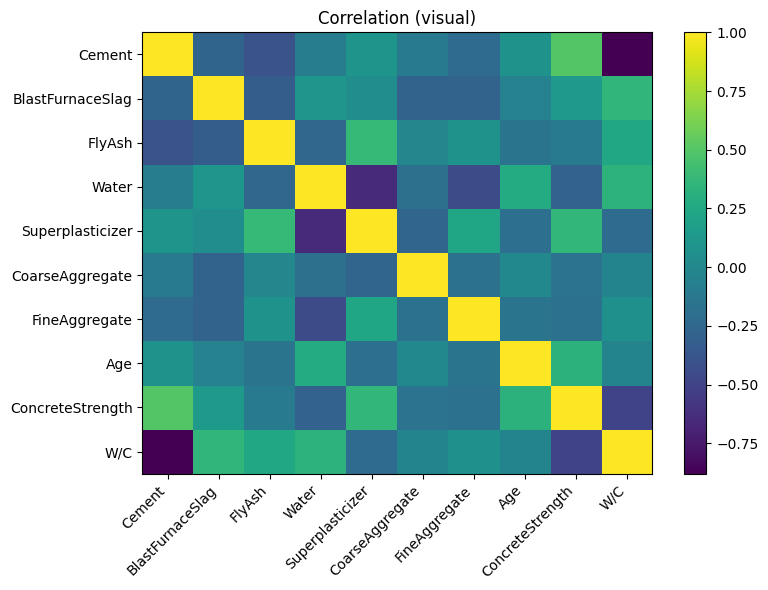

In [6]:
corr = df.corr()
plt.figure(figsize=(8,6))
plt.imshow(corr.values, aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha='right')
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Correlation (visual)")
plt.tight_layout()
plt.show()

5. Preprocessing

In [7]:
# Drop rows with NA (or impute)
df = df.dropna()

# Split features & label
X = df.drop(columns=[target_col])
y = df[target_col].values

# If any non-numeric columns exist, one-hot encode
X = pd.get_dummies(X, drop_first=True)

# Train-test split
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

# Scaling (useful for some models; tree models don't strictly need it but it's safe)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

6. baseline models

In [8]:
def metrics(y_true, y_pred):
    return {
        "r2": r2_score(y_true, y_pred),
        "mae": mean_absolute_error(y_true, y_pred),
        "rmse": np.sqrt(mean_squared_error(y_true, y_pred))
    }

models = {
    "Linear": LinearRegression(),
    "RandomForest": RandomForestRegressor(random_state=42, n_estimators=200),
    "GradientBoosting": GradientBoostingRegressor(random_state=42)
}

results = {}
for name, model in models.items():
    # For tree models, pass unscaled X (but scaled also OK). We'll use scaled for consistency.
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    results[name] = metrics(y_test, preds)
    
pd.DataFrame(results).T

,r2,mae,rmse
Linear,0.632646,7.638457,9.729270
RandomForest,0.887809,3.718817,5.376701
GradientBoosting,0.893250,3.884701,5.244705


7. Hyperparameter tuning (RandomizedSearchCV) for GradientBoosting

In [9]:
param_dist = {
    "n_estimators": [100, 150, 200, 300],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "max_depth": [2, 3, 4, 5],
    "subsample": [0.6, 0.8, 1.0],
    "min_samples_split": [2, 3, 4],
    "min_samples_leaf": [1, 2, 3]
}
# Good practice: if dataset is small, reduce n_iter and cv:
n_samples = X.shape[0]
cv_folds = min(5, max(2, n_samples//10))  # heuristic
n_iter_search = 20 if n_samples >= 200 else 8

gbr = GradientBoostingRegressor(random_state=42)
rs = RandomizedSearchCV(gbr, param_distributions=param_dist,
                        n_iter=n_iter_search, cv=cv_folds, scoring='r2',
                        random_state=42, n_jobs=-1, verbose=1)
rs.fit(X_train_scaled, y_train)
print("Best params:", rs.best_params_)
best_model = rs.best_estimator_

# Evaluate best model
preds_best = best_model.predict(X_test_scaled)
metrics_best = metrics(y_test, preds_best)
print("Best model metrics:", metrics_best)

# Cross-validated score on full dataset (optional)
cv_score = cross_val_score(best_model, scaler.transform(X), y, cv=cv_folds, scoring='r2')
print("CV R2 mean (best model):", cv_score.mean())

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params: {'subsample': 0.8, 'n_estimators': 300, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 3, 'learning_rate': 0.1}
Best model metrics: {'r2': 0.9236774213228883, 'mae': 3.008471406768358, 'rmse': np.float64(4.434700107483591)}
CV R2 mean (best model): 0.5555397188572788


8. feature importance & interpretability

Age                 0.368568
W/C                 0.321453
BlastFurnaceSlag    0.088366
Superplasticizer    0.059360
Water               0.051543
Cement              0.043434
FineAggregate       0.039326
CoarseAggregate     0.020006
FlyAsh              0.007944
dtype: float64

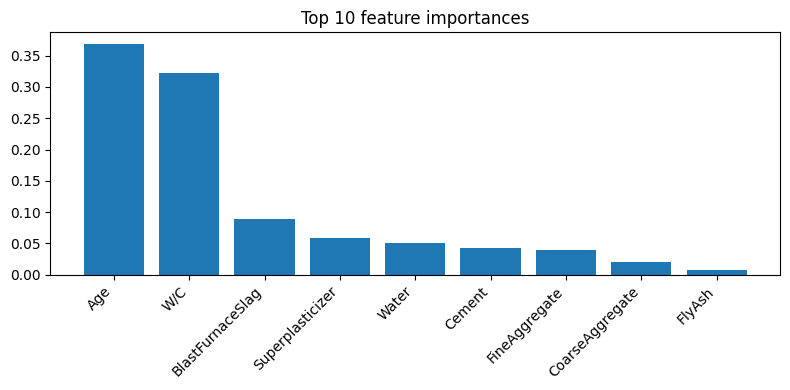

C:\Users\Acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


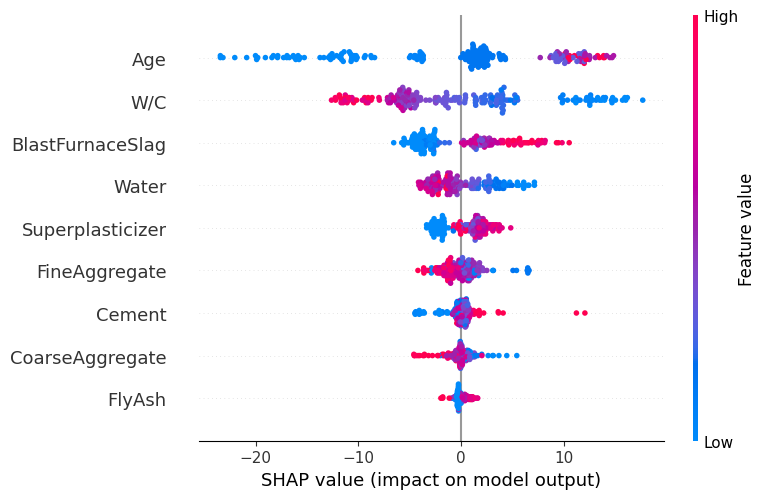

In [11]:
importances = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)
display(importances.head(10))
plt.figure(figsize=(8,4))
plt.bar(importances.index[:10], importances.values[:10])
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 feature importances")
plt.tight_layout()
plt.show()

# Optionally run SHAP (if installed) for per-sample explanations:
import shap
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_scaled)
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

 9. simple optimization routine (search-based)

In [ ]:
# Idea: sample candidate mixes within observed ranges, predict, and pick those close to target.
feature_ranges = {col: (X[col].min(), X[col].max()) for col in X.columns}

def suggest_mixes(target_strength, n_candidates=10000, top_k=10, tolerance=None, prefer_low_cement=True):
    rng = np.random.RandomState(0)
    candidates = pd.DataFrame({col: rng.uniform(low, high, n_candidates) for col, (low, high) in feature_ranges.items()})
    # If 'Age' present, consider rounding to nearest whole day
    age_cols = [c for c in candidates.columns if 'age' in c.lower()]
    for a in age_cols:
        candidates[a] = np.clip(np.round(candidates[a]), feature_ranges[a][0], feature_ranges[a][1])
    # Predict
    cand_scaled = scaler.transform(candidates)
    preds = best_model.predict(cand_scaled)
    candidates['pred_strength'] = preds
    candidates['abs_err'] = np.abs(preds - target_strength)
    if tolerance is not None:
        candidates = candidates[candidates['abs_err'] <= tolerance]
    if candidates.shape[0] == 0:
        top = candidates.nsmallest(top_k, 'abs_err')
    else:
        if prefer_low_cement and 'Cement (component 1)(kg in a m^3 mixture)' in candidates.columns:
            top = candidates.sort_values(['abs_err', 'Cement (component 1)(kg in a m^3 mixture)']).head(top_k)
        else:
            top = candidates.nsmallest(top_k, 'abs_err')
    return top

# Example usage:
suggested = suggest_mixes(target_strength=50.0, n_candidates=5000, top_k=5)
display(suggested)


,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,W/C,pred_strength,abs_err
547,458.391249,296.203871,49.751782,123.198043,4.574043,820.971949,916.740702,258.0,1.131834,49.998722,0.001278
4831,124.343708,328.822963,7.389966,184.887798,22.627729,858.519766,920.349094,87.0,1.480928,50.005856,0.005856
1234,104.038819,291.201724,110.362054,197.854969,31.585955,991.726444,847.706480,257.0,1.233307,49.991350,0.008650
2885,445.350599,160.338265,131.730093,241.012302,21.276209,1030.290341,656.260320,192.0,1.247101,50.009596,0.009596
520,340.130988,260.777510,183.773376,232.644055,21.589696,1074.420815,788.429906,13.0,0.393169,49.989914,0.010086


In [ ]:
# Cell 10: save artifacts
os.makedirs("/mnt/data/concrete_ml_artifacts", exist_ok=True)
joblib.dump(best_model, "/mnt/data/concrete_ml_artifacts/concrete_best_gb.pkl")
joblib.dump(scaler, "/mnt/data/concrete_ml_artifacts/scaler.pkl")
suggested.to_csv("/mnt/data/concrete_ml_artifacts/suggested_mixes_40MPa.csv", index=False)
print("Saved artifacts to /mnt/data/concrete_ml_artifacts/")

# Cell 11: wrap-up notes (print summary)
print("Evaluation (test):", metrics_best)
print("Top features:", importances.head(6))

Saved artifacts to /mnt/data/concrete_ml_artifacts/
Evaluation (test): {'r2': 0.9236774213228883, 'mae': 3.008471406768358, 'rmse': np.float64(4.434700107483591)}
Top features: Age                 0.368568
W/C                 0.321453
BlastFurnaceSlag    0.088366
Superplasticizer    0.059360
Water               0.051543
Cement              0.043434
dtype: float64
